# Load OpenMonkeyStudio Data

In [60]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir' : '/data/LiftFly3D/openmonkey/OMS_Dataset/', # change the path 
           'out_dir'        : './out',
           'subjects'       : ["7", "9"],#, "9a", "9b", "10", "11"],
           'train_subjects' : ['7'],#["7", "9a", "9b", "10", "11"],
           'test_subjects'  : ["9"]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
cameras, pose_result = load_data(par['data_dir'], par["subjects"])

# split data into training and test
train_2d = {k:np.array(v["points2d"]) for (k,v) in pose_result.items() if k in par["train_subjects"]}
test_2d = {k:np.array(v["points2d"]) for (k,v) in pose_result.items() if k in par["test_subjects"]}
train_3d = {k:np.array(v["points3d"]) for (k,v) in pose_result.items() if k in par["train_subjects"]}
test_3d = {k:np.array(v["points3d"]) for (k,v) in pose_result.items() if k in par["test_subjects"]}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
processing batch 7
processing batch 9


In [61]:
print("convert to camera coordinate system")
# convert 3d points into camera coordinate system
for btch in train_3d.keys():
    cam_id = pose_result[btch]['cam_id'][idx]
    R, T, intr, distort, vis_pts = cameras[btch][cam_id]
    train_3d[btch] = world_to_camera(train_3d[btch], R, T)
        
for btch in test_3d.keys():
    cam_id = pose_result[btch]['cam_id'][idx]
    R, T, intr, distort, vis_pts = cameras[btch][cam_id]
    test_3d[btch] = world_to_camera(test_3d[btch].copy(), R, T)

print("bone length normalize")
# 3d points bone-length normalize
for btch in train_3d.keys():
    train_3d[btch] = bone_length_normalize(template=train_3d['7'], d=train_3d[btch], leaves=par_data['vis']['leaves'], parents=par_data['vis']['parents'])
    
for btch in test_3d.keys():
    test_3d[btch] = bone_length_normalize(template=train_3d['7'], d=test_3d[btch], leaves=par_data['vis']['leaves'], parents=par_data['vis']['parents'])
        
# unit norm of 2d points
train_2d = {k: v / np.linalg.norm(v.reshape(v.shape[0],-1), axis=1)[:,np.newaxis,np.newaxis] for (k,v) in train_2d.items()}
test_2d = {k: v / np.linalg.norm(v.reshape(v.shape[0],-1), axis=1)[:,np.newaxis,np.newaxis] for (k,v) in test_2d.items()}

convert to camera coordinate system
bone length normalize


# Train LiftPose3D Network on DeepFly3D Data

In [62]:
from liftpose.main import train as lp3d_train

lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           roots=par['roots'], target_sets=par['target_sets'], out_dir=par['out_dir'])

[main.py:189]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/openmonkey/out/stat_2d.pth.tar.
[main.py:218]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/openmonkey/outstat_3d.pth.tar.
[main.py:239]:INFO:Starting training model.
[main.py:246]:DEBUG:
==================Options=================
[main.py:247]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/openmonkey/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/openmonkey/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/openmonkey/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:248]:DEBUG:==================================

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  1.69479|: 100%|██████████| 550/550 [00:13<00:00, 41.71it/s]
Epoch 001 | LR  0.00100 | Loss Test  1.02409 | Loss Train  0.89782|: 100%|██████████| 550/550 [00:13<00:00, 42.03it/s]
Epoch 002 | LR  0.00100 | Loss Test  0.91257 | Loss Train  0.86235|: 100%|██████████| 550/550 [00:12<00:00, 43.11it/s]
Epoch 003 | LR  0.00100 | Loss Test  0.91480 | Loss Train  0.83683|: 100%|██████████| 550/550 [00:12<00:00, 43.88it/s]
Epoch 004 | LR  0.00100 | Loss Test  1.00479 | Loss Train  0.82363|:  73%|███████▎  | 400/550 [00:09<00:03, 40.18it/s]


KeyboardInterrupt: 

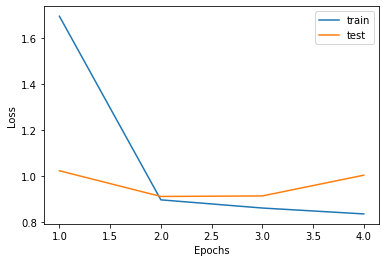

In [63]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [64]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:270]:INFO:starting testing in path: ./out
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:57]:INFO:total params: 4.27M
[lift.py:63]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:71]:INFO:ckpt loaded (epoch: 3 | err: 0.8196190735725262)
[lift.py:109]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/openmonkey/out/test_results.pth.tar


# Run Trained LiftPose3D Network on the Test Data

In [66]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, _ = load_test_results(data, stat_2d, stat_3d)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

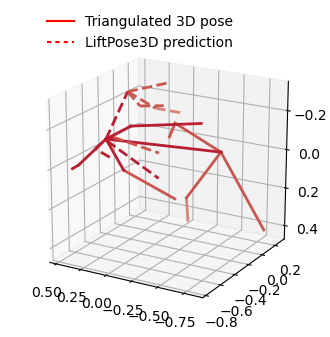

In [67]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

t = 330
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"]) 